In [1]:
# Common useful packages
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns
import scipy
import numpy as np
import copy
import spectral
import pickle

# module that is useful for reloading packages
import importlib

# Scripts associated with the SML4SI textbook
import hyperspectral_gta_data as hsi_data
import scripts_M2 as sm2
from hsiViewer import hsi_viewer_ROI as hvr

# set the directory where data will be downloaded and accessed
# (This directory will be saved in a config file and used each time you use hyperspectral_gta_data, 
# so you don't need to run the 'set_data_dir' function every time you use hyperspectral_gta_data.)
hsi_data.set_data_dir('/Users/giasmith/spectral_data')

In [2]:
# Helper functions

def add_white(im, tgt_spectra):
    im.t = tgt_spectra
    
    # Compute the mean and covariance
    im.mu = np.mean(im.dataList, axis=0)
    #im.mu = np.reshape(imageMean, (len(imageMean),1))
    im.C = np.cov(im.dataList.T)
    
    # Compute the eigenvectors, eigenvalues, and whitening matrix
    evals,evecs = np.linalg.eig(im.C)
    # truncate the small eigenvalues to stablize the inverse
    evals[evals<10**(-8)] = 10**(-8)
    DiagMatrix = np.diag(evals**(-1/2))
    im.W = np.matmul(evecs,DiagMatrix)
    
    # Whiten the image
    im_demean = im.List-im.mu
    im.ListW = np.matmul(im.W.T,im_demean.T).T 
    
    # Whiten the target
    im.tW = np.matmul(im.W.T,(im.t-im.mu).T).T
    
    return im

def ace_det(im):            
    nr = im.nrows # number of rows in the image
    nc = im.ncols # number of columns in the image
    nt = im.tW.shape[0] # number of target spectra
    # numerator is dot product of each pixel and the target (whitened)
    numerator = np.matmul(im.ListW,im.tW.T) #XT
    # denomenator is norm of each pixel times the norm of the target (whitened)
    Xnorm = np.reshape(np.sqrt(np.sum(im.ListW**2, axis=1)), (nr*nc,1))
    Tnorm = np.reshape(np.sqrt(np.sum(im.tW**2, axis=1)), (nt,1))
    denom = np.matmul( Xnorm, Tnorm.T) #sqrt(XX)*sqrt(TT)
    # take the ratio and reshape
    D = numerator / denom # XT/(sqrt(XX)*sqrt(TT))
    D = np.reshape(D, (nr, nc, nt))
    return D  

def mf_det(im):
    nr = im.nrows # number of rows in the image
    nc = im.ncols # number of columns in the image
    nt = im.tW.shape[0] # number of target spectra
    # numerator is dot product of each pixel and the target (whitened)
    numerator = np.matmul(im.ListW,im.tW.T) #XT
    # denomenator is the norm of the target squared (whitened)
    denom = np.reshape(np.sum(im.ListW**2, axis=1), (nr*nc,1)) #XX
    # take the ratio and reshape
    D = numerator / denom #XT/XX
    D = np.reshape(D, (nr, nc, nt))
    return D 


def plot_hist(det, roiData, nbins=50, detectorName='ACE'):
    
    # calculate the masks
    states_Bacc = np.squeeze(roiData.masks['Baccharis Halimifolia']).astype(int)

    # calculate output probabilities    
    Bacc_det = det[states_Bacc==1]
    Bacc_mean = np.mean(Bacc_det)
    Bacc_std = np.std(Bacc_det)

    N_det = det[states_Bacc==0]
    N_mean = np.mean(N_det)
    N_std = np.std(N_det)

    print(f'Bacc: mean={Bacc_mean}, std={Bacc_std}')
    print(f'None: mean={N_mean}, std={N_std}')

    # plot output pdfs

    # plot historgrams of the output
    plt.figure(figsize=(12,4))
    plt.subplot(1, 3, 1) # layout to make 1 row, 2 columns of plots, and create to location 1.
    ax1 = sns.histplot(data=N_det, stat="probability", bins=nbins, kde=True, label=f'{detectorName} None');
    ax1 = sns.histplot(data=Bacc_det, stat="probability", bins=nbins, kde=True, label=f'{detectorName} Baccharis');
    ax1.set(xlabel='x ', ylabel='Frequency', title='Observation Histograms')
    ax1.legend();

    # plot the probability density functions
    ax2 = plt.subplot(1, 3, 2) # layout to make 1 row, 2 columns of plots, and create to location 2.
    x = np.linspace(ax1.get_xlim()[0], ax1.get_xlim()[1], 100) # generate a list of x-values
    yn = scipy.stats.norm.pdf(x, loc=N_mean, scale=N_std) # compute the PDF at these x-values
    ax2.plot(x,yn, label='Obs None')
    yBacc = scipy.stats.norm.pdf(x, loc=Bacc_mean, scale=Bacc_std) # compute the PDF at these x-values
    ax2.plot(x,yBacc, label='Obs Baccharis')
    ax2.legend()
    ax2.set(xlabel='x ', ylabel='PDF', 
        title=f'Observation PDFs');

    # plot the cumulative density functions
    ax3 = plt.subplot(1, 3, 3) # layout to make 1 row, 2 columns of plots, and create to location 2.
    ax3.plot(x,yBacc/(yBacc+yn), label='Obs Bacc')
    ax3.legend()
    ax3.set(xlabel='x ', ylabel='CDF', 
        title=f'Detection CDF');
    plt.tight_layout()


# 1. Download the data

In [3]:
# Here are the datasets available through the hyperspectral_gta_data package
hsi_data.available_datasets()

Available Images:
   WashingtonDC
   MicroscenePolymers
   DetectionImagery_CookeCity_RIT
   VegBaccharisUPWINS
   PaintDetectionUPWINS
   indian_pines
   pavia_centre
   pavia_university
   AVIRIS_Cuprite
   ENMAP_Cuprite
Available Spectral Libraries:
   GHISACONUS_2008_001_speclib
   Microscene_Polymers_Library
   UPWINS_4_16_2024
   Detection_Library_Cooke_City_RIT
   USGS_splib07b


## Download the hyperspectral image

In [4]:
# Download and use the Cooke Cite image:
hsi_data.download('VegBaccharisUPWINS')
fname = hsi_data.get_fname('VegBaccharisUPWINS')

Available Files:
/Users/giasmith/spectral_data/spectral_images/Vegetation_Baccharis_halmifolia_UPWINS/.DS_Store
/Users/giasmith/spectral_data/spectral_images/Vegetation_Baccharis_halmifolia_UPWINS/Morven_Baccharis_h_or_ref.sli
/Users/giasmith/spectral_data/spectral_images/Vegetation_Baccharis_halmifolia_UPWINS/Morven_Baccharis_h_or_ref.hdr
Primary Image Filename:
/Users/giasmith/spectral_data/spectral_images/Vegetation_Baccharis_halmifolia_UPWINS/Morven_Baccharis_h_or_ref


In [7]:
# load the Cooke City hyperspectral iamge
#fname = 'C:/spectral_data\spectral_images\Vegetation_Baccharis_halmifolia_UPWINS/Morven_Baccharis_h_or_ref'
#fname_hdr = 'C:/spectral_data\spectral_images\Vegetation_Baccharis_halmifolia_UPWINS/Morven_Baccharis_h_or_ref.hdr'
fname_hdr= fname+'.hdr'
# Open the image and read into an array
im = spectral.envi.open(fname_hdr)
wl_im = np.asarray(im.bands.centers)
# Load the image into memory
im.Arr = im.load()
imArr = im.Arr
mask = np.sum(im.Arr, axis=2)>0
print(f'Shape of ImArr = {im.Arr.shape}')
im.List = np.reshape(im.Arr, (im.nrows*im.ncols, im.nbands))
im.ListMask = np.reshape(mask, (im.nrows*im.ncols))
print(f'Shape of imList = {im.List.shape}')
im.dataList = im.List[im.ListMask==1,:]

Shape of ImArr = (300, 600, 343)
Shape of imList = (180000, 343)


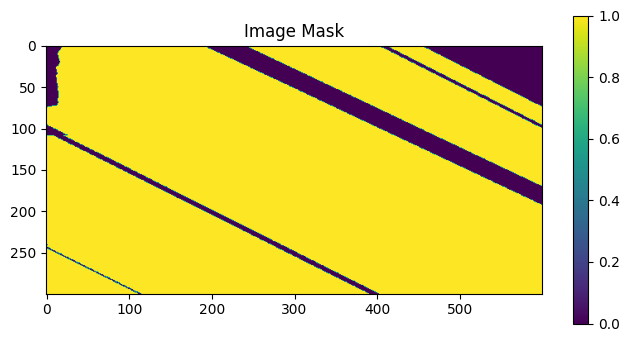

In [8]:
plt.figure(figsize=(8,4))
plt.imshow(mask)
plt.colorbar()
plt.title('Image Mask');

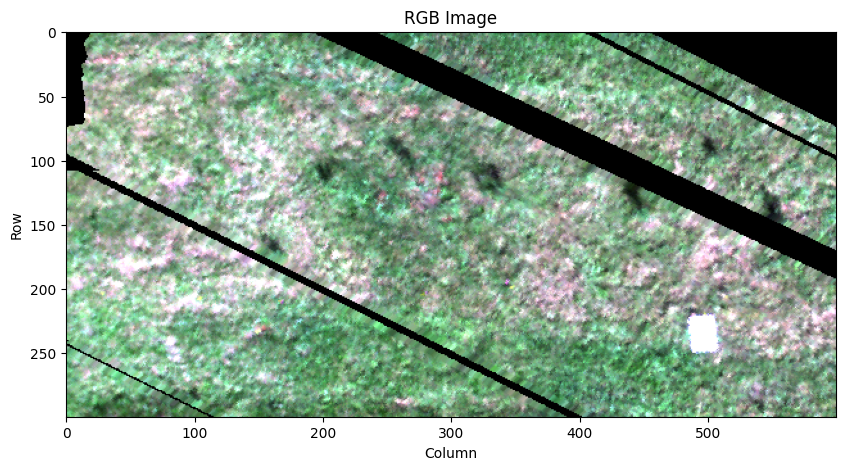

In [9]:
# display the image
sm2.display_RGB(im.Arr, wl_im, rotate=False)
plt.title('RGB Image');

# Load ROI Ground Truth


In [14]:
#fname = 'Users/giasmith/spectral_data/spectral_images/UPWINS Baccharis Halimifolia.pkl'
fname = '/Users/giasmith/spectral_data/spectral_images/UPWINS Baccharis Halimifolia.pkl'
with open(fname, 'rb') as f:
    roiData = pickle.load(f)

### Examine some of the information in the roiData ground truth dictionary

In [15]:
roiData.names

['Baccharis Halimifolia',
 'Flag',
 'Ribbon',
 'Background Healthy',
 'Background Scenesced']

In [16]:
roiData.colors['Baccharis Halimifolia']

'#fa3232'

In [17]:
roiData.masks['Baccharis Halimifolia']

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

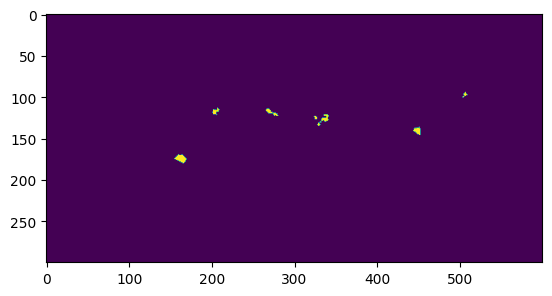

In [18]:
plt.imshow(np.squeeze(roiData.masks['Baccharis Halimifolia']).astype(int))

In [19]:
roiData.df

Name    Color  Pixel_x  Pixel_y  399.096008  400.854004  \
0    Baccharis Halimifolia  #fa3232      175      155      0.0282      0.0368   
1    Baccharis Halimifolia  #fa3232      174      156      0.0282      0.0368   
2    Baccharis Halimifolia  #fa3232      175      156      0.0334      0.0369   
3    Baccharis Halimifolia  #fa3232      173      157      0.0282      0.0368   
4    Baccharis Halimifolia  #fa3232      174      157      0.0332      0.0369   
..                     ...      ...      ...      ...         ...         ...   
249   Background Scenesced  #baae80      108      172      0.0547      0.0529   
250   Background Scenesced  #baae80      104      173      0.0451      0.0459   
251   Background Scenesced  #baae80      105      173      0.0460      0.0515   
252   Background Scenesced  #baae80      106      173      0.0425      0.0466   
253   Background Scenesced  #baae80      105      174      0.0406      0.0417   

     402.612  404.369995  406.127991  407.885986  ...  984.531006  986.289001  \
0     0.0366      0.0344      0.0230      0.0356  ...      0.4109      0.3889   
1     0.0366      0.0344      0.0230      0.0356  ...      0.4109      0.3889   
2     0.0309      0.0318      0.0287      0.0324  ...      0.4090      0.3906   
3     0.0366      0.0344      0.0230      0.0356  ...      0.4109      0.3889   
4     0.0311      0.0319      0.0285      0.0325  ...      0.4091      0.3905   
..       ...         ...         ...         ...  ...         ...         ...   
249   0.0493      0.0510      0.0494      0.0515  ...      0.3388      0.3305   
250   0.0377      0.0331      0.0342      0.0394  ...      0.3737      0.2927   
251   0.0426      0.0450      0.0347      0.0380  ...      0.3536      0.3609   
252   0.0452      0.0468      0.0481      0.0403  ...      0.2934      0.3556   
253   0.0425      0.0402      0.0379      0.0365  ...      0.3062      0.3493   

     988.047974  989.80603  991.564026  993.322021  995.080017  996.838013  \
0        0.4285     0.3314      0.3840      0.3716      0.3766      0.3416   
1        0.4285     0.3314      0.3840      0.3716      0.3766      0.3416   
2        0.4206     0.3356      0.3441      0.3810      0.3301      0.3485   
3        0.4285     0.3314      0.3840      0.3716      0.3766      0.3416   
4        0.4209     0.3354      0.3456      0.3806      0.3319      0.3482   
..          ...        ...         ...         ...         ...         ...   
249      0.3511     0.3505      0.3243      0.3076      0.3674      0.3502   
250      0.3801     0.3776      0.3098      0.4160      0.2905      0.3880   
251      0.3262     0.2731      0.3314      0.3233      0.3458      0.3880   
252      0.2697     0.3226      0.3806      0.3279      0.3358      0.3361   
253      0.3532     0.3006      0.3403      0.3349      0.2567      0.3691   

     998.596008  1000.349976  
0        0.3801       0.3947  
1        0.3801       0.3947  
2        0.3527       0.3558  
3        0.3801       0.3947  
4        0.3538       0.3573  
..          ...          ...  
249      0.3996       0.3676  
250      0.3429       0.4168  
251      0.3494       0.4168  
252      0.3974       0.2698  
253      0.2475       0.3204  

[1410 rows x 347 columns]

# Load Spectral Library

In [20]:
# To download and use the Cooke City spectral library image:
hsi_data.download('UPWINS_4_16_2024')
fname = hsi_data.get_fname('UPWINS_4_16_2024')

Available Files:
/Users/giasmith/spectral_data/spectral_libraries/UPWINS_4_16_2024/UPWINS_4_16_2024.sli
/Users/giasmith/spectral_data/spectral_libraries/UPWINS_4_16_2024/UPWINS_4_16_2024.hdr
Primary Image Filename:
/Users/giasmith/spectral_data/spectral_libraries/UPWINS_4_16_2024/UPWINS_4_16_2024.sli


In [21]:
#fname = 'C:/spectral_data/spectral_libraries/UPWINS_4_16_2024/UPWINS_4_16_2024.sli'
fname_hdr = '/Users/giasmith/spectral_data/spectral_libraries/UPWINS_4_16_2024/UPWINS_4_16_2024.hdr'

# Open the image and read into an array
lib = spectral.envi.open(fname_hdr, fname)
wl = np.asarray(im.bands.centers)
# Load the image into memory
names = lib.names
spectra = lib.spectra
wl_lib = np.asarray(lib.bands.centers)

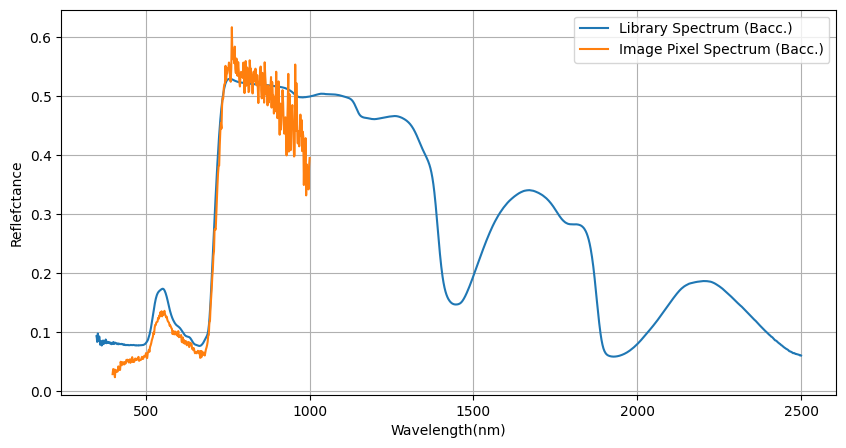

In [22]:
# Plot an image pixel spectrum and a library spectrum for comparison
plt.figure(figsize=(10,5))
plt.plot(wl_lib, spectra[0,:], label='Library Spectrum (Bacc.)')
plt.plot(wl_im, imArr[175,155,:].flatten(), label='Image Pixel Spectrum (Bacc.)')
plt.legend()
plt.grid(True)
plt.xlabel('Wavelength(nm)')
plt.ylabel('Reflefctance');

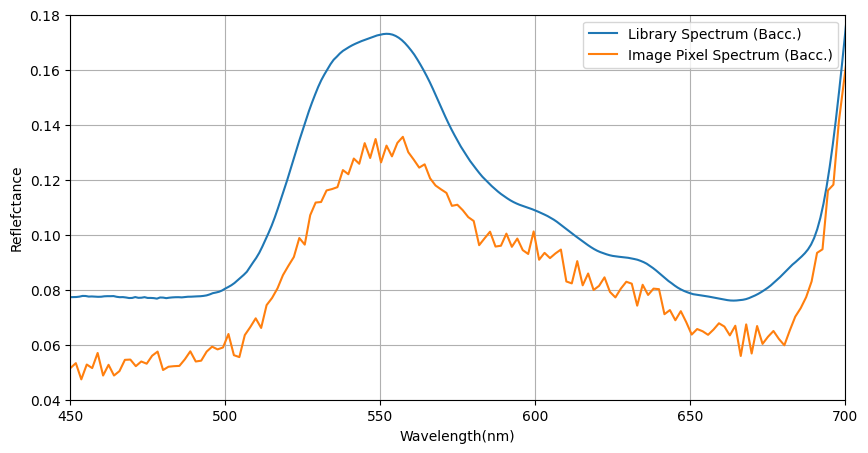

In [23]:
# Plot an image pixel spectrum and a library spectrum for comparison
plt.figure(figsize=(10,5))
plt.plot(wl_lib, spectra[0,:], label='Library Spectrum (Bacc.)')
plt.plot(wl_im, imArr[175,155,:].flatten(), label='Image Pixel Spectrum (Bacc.)')
plt.xlim((450,700))
plt.ylim((0.04,0.18))
plt.legend()
plt.grid(True)
plt.xlabel('Wavelength(nm)')
plt.ylabel('Reflefctance');

Observations:
1. The image and library are both in nanometers, so we don't need to rescale the wavelengths
2. We need to resample the image spectrum to match the library.
3. The image seems much noiser than the library, especially for wavelengths above 750nm.  Hmmm....

In [24]:
resampler = spectral.BandResampler(wl_lib, wl_im)
spectra = resampler(lib.spectra.T).T
wl = wl_im

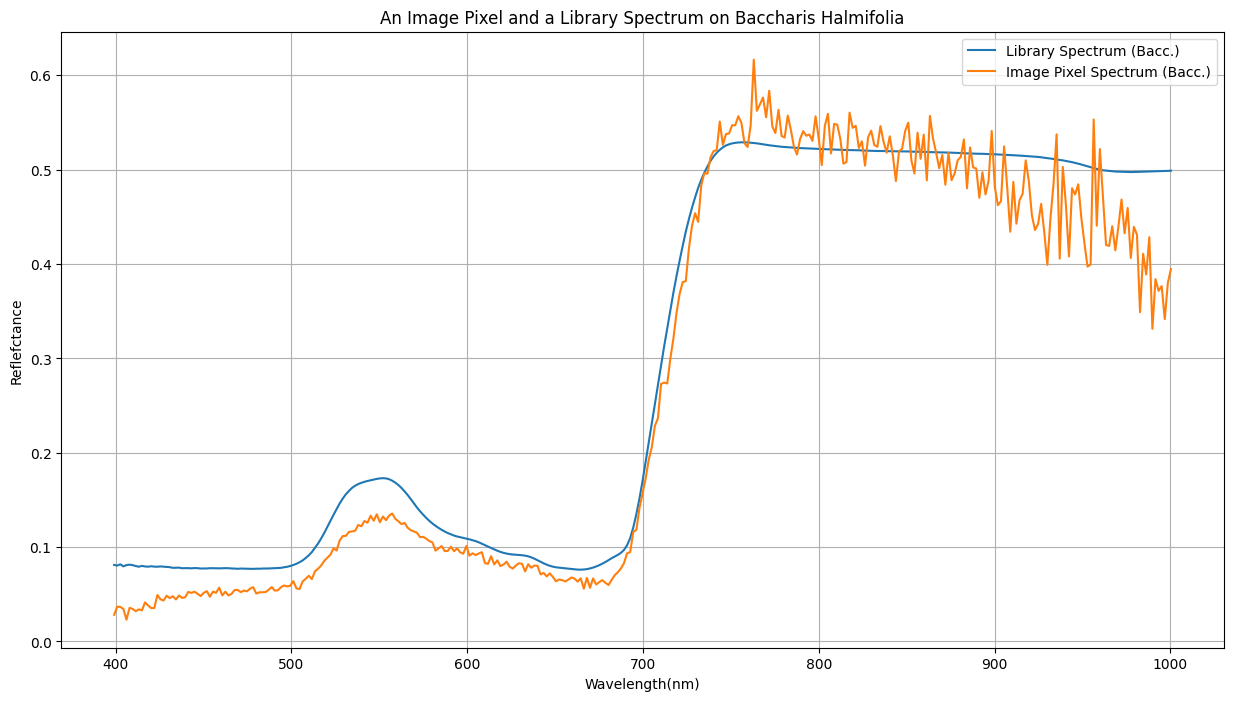

In [25]:
# Plot an image pixel spectrum and a library spectrum for comparison
plt.figure(figsize=(15,8))
plt.plot(wl, spectra[0,:], label='Library Spectrum (Bacc.)')
plt.plot(wl, imArr[175,155,:].flatten(), label='Image Pixel Spectrum (Bacc.)')
plt.legend()
plt.grid(True)
plt.xlabel('Wavelength(nm)')
plt.ylabel('Reflefctance')
plt.title('An Image Pixel and a Library Spectrum on Baccharis Halmifolia');

# Exploritory Data Analysis on Spectral Library

In [26]:
# print the names of the library spectra, but replace the newline in the print with ' | ' to keep this on one line for nice viewing.
for n in names:
    print(n,end=' | ')

Baccharis_Halimif_L_Y1G_H00000 | Baccharis_Halimif_L_Y1G_H00001 | Baccharis_Halimif_L_Y1G_H00002 | Baccharis_Halimif_L_Y1G_H00003 | Baccharis_Halimif_L_Y1G_H00004 | Baccharis_Halimif_L_Y1G_H00005 | Baccharis_Halimif_L_Y1G_H00006 | Baccharis_Halimif_L_Y1G_H00007 | Baccharis_Halimif_L_Y1G_H00008 | Baccharis_Halimif_L_Y1G_H00009 | Baccharis_Halimif_L_Y1G_H00010 | Baccharis_Halimif_L_Y1G_H00011 | Baccharis_Halimif_L_Y1G_H00012 | Baccharis_Halimif_L_Y1G_H00013 | Baccharis_Halimif_L_Y1G_H00014 | Baccharis_Halimif_L_Y1G_H00015 | Baccharis_Halimif_L_Y1G_H00016 | Baccharis_Halimif_L_Y1G_H00017 | Baccharis_Halimif_L_Y1G_H00018 | Baccharis_Halimif_L_Y1G_H00019 | Baccharis_Halimif_L_Y1G_H00020 | Baccharis_Halimif_RS_Y1G_H00000 | Baccharis_Halimif_RS_Y1G_H00001 | Baccharis_Halimif_RS_Y1G_H00002 | Baccharis_Halimif_SA_Y1G_H00000 | Baccharis_Halimif_SA_Y1G_H00001 | Baccharis_Halimif_SA_Y1G_H00002 | Baccharis_halimifoli_L_RE_H00000 | Baccharis_halimifoli_L_RE_H00001 | Baccharis_halimifoli_L_RE_H00002 

In [27]:
tgt_indices = []
tgt_names = []
for i in range(len(names)):
    if names[i][:4]=='Bacc':
        tgt_indices.append(i)
        tgt_names.append(names[i])

spec = spectra[tgt_indices,:]
print(f'There are {len(tgt_indices)} target spectra:')
for n in tgt_names:
    print(n,end=' | ')

There are 31 target spectra:
Baccharis_Halimif_L_Y1G_H00000 | Baccharis_Halimif_L_Y1G_H00001 | Baccharis_Halimif_L_Y1G_H00002 | Baccharis_Halimif_L_Y1G_H00003 | Baccharis_Halimif_L_Y1G_H00004 | Baccharis_Halimif_L_Y1G_H00005 | Baccharis_Halimif_L_Y1G_H00006 | Baccharis_Halimif_L_Y1G_H00007 | Baccharis_Halimif_L_Y1G_H00008 | Baccharis_Halimif_L_Y1G_H00009 | Baccharis_Halimif_L_Y1G_H00010 | Baccharis_Halimif_L_Y1G_H00011 | Baccharis_Halimif_L_Y1G_H00012 | Baccharis_Halimif_L_Y1G_H00013 | Baccharis_Halimif_L_Y1G_H00014 | Baccharis_Halimif_L_Y1G_H00015 | Baccharis_Halimif_L_Y1G_H00016 | Baccharis_Halimif_L_Y1G_H00017 | Baccharis_Halimif_L_Y1G_H00018 | Baccharis_Halimif_L_Y1G_H00019 | Baccharis_Halimif_L_Y1G_H00020 | Baccharis_Halimif_RS_Y1G_H00000 | Baccharis_Halimif_RS_Y1G_H00001 | Baccharis_Halimif_RS_Y1G_H00002 | Baccharis_Halimif_SA_Y1G_H00000 | Baccharis_Halimif_SA_Y1G_H00001 | Baccharis_Halimif_SA_Y1G_H00002 | Baccharis_halimifoli_L_RE_H00000 | Baccharis_halimifoli_L_RE_H00001 | Bacc

In [28]:
tnames_short = []
for n in tgt_names:
    tnames_short.append(n.replace("Baccharis", "Bacc").replace("halimifoli", "h").replace("Halimif", "h").replace("000", ""))

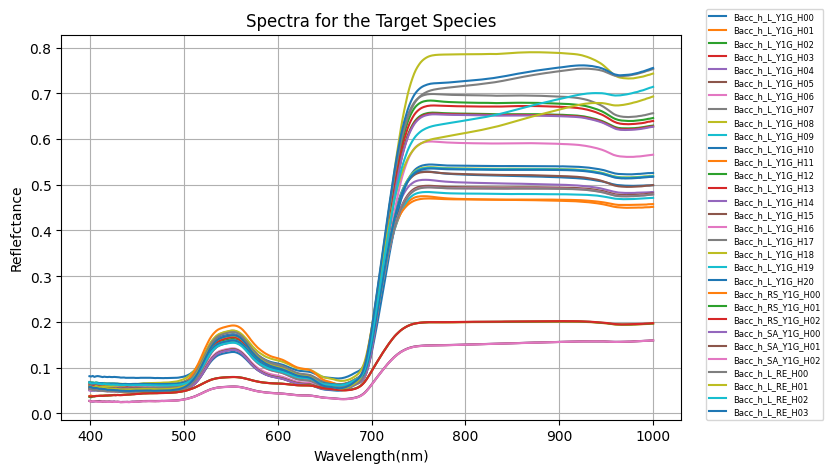

In [29]:
plt.figure(figsize=(8,5))
for i in tgt_indices:
    plt.plot(wl, spec[i,:], label=tnames_short[i]);
plt.legend(loc=(1.04,0), fontsize=6);
plt.grid(True)
plt.xlabel('Wavelength(nm)')
plt.ylabel('Reflefctance')
plt.title('Spectra for the Target Species');

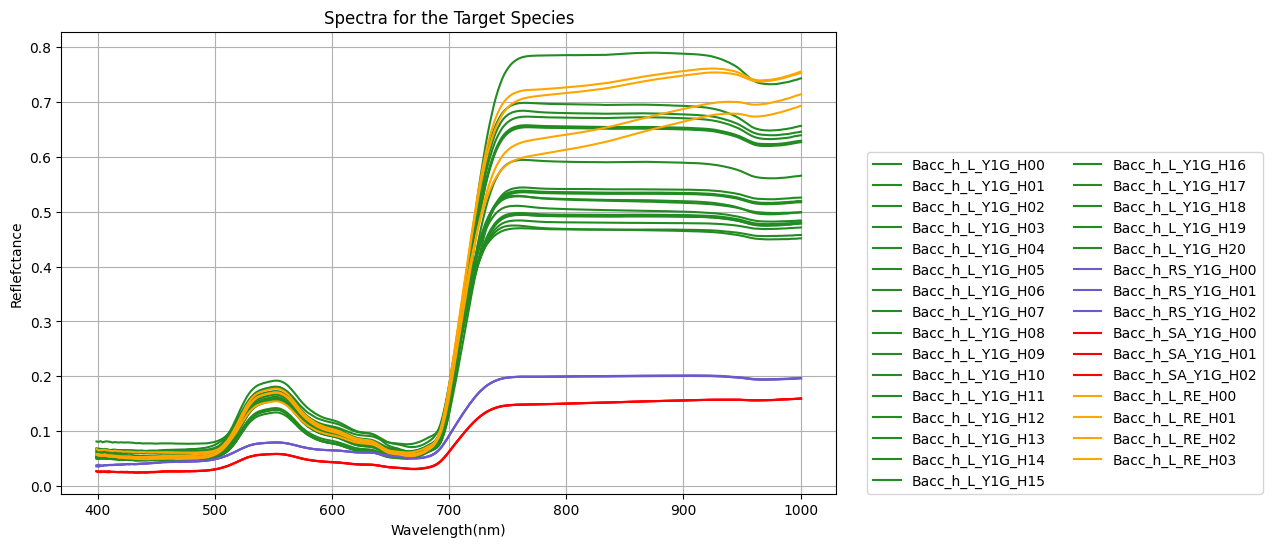

In [30]:
plt.figure(figsize=(10,6))
for i in tgt_indices:
    if '_RE_' in tnames_short[i]:
        plt.plot(wl, spec[i,:], label=tnames_short[i], c='orange');
    elif '_L_' in tnames_short[i]:
        plt.plot(wl, spec[i,:], label=tnames_short[i], c='forestgreen');
    elif '_RS_' in tnames_short[i]:
        plt.plot(wl, spec[i,:], label=tnames_short[i], c='slateblue');
    elif '_SA_' in tnames_short[i]:
        plt.plot(wl, spec[i,:], label=tnames_short[i], c='red');
plt.legend(loc=(1.04,0), fontsize=10, ncols=2);
plt.grid(True)
plt.xlabel('Wavelength(nm)')
plt.ylabel('Reflefctance')
plt.title('Spectra for the Target Species');

Observation:
1. There seems to be 4 groups of spectra here, RE=Re-Emergence, SA=?, RS=?, and L=Leaf

# Test Target Detection

In [31]:
im = add_white(im, spec)

In [32]:
ace = ace_det(im)
ace_max_val = np.max(ace, axis=2)*mask
mf = mf_det(im)
mf_max_val = np.max(mf, axis=2)*mask

Bacc: mean=0.200510333754307, std=0.0692615491702177
None: mean=0.046870064217813485, std=0.052607810874004124


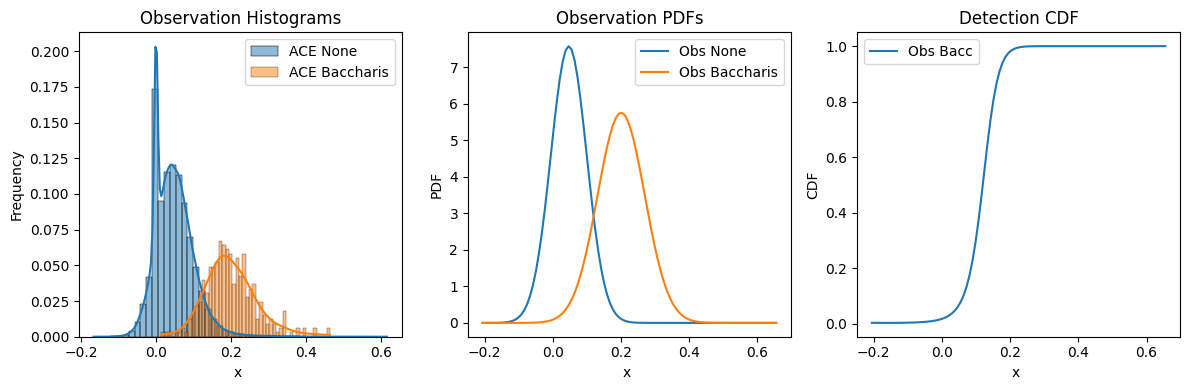

In [33]:
plot_hist(ace_max_val, roiData, detectorName='ACE')

Bacc: mean=0.21035101829158323, std=0.13839295200366739
None: mean=0.03869730851434424, std=0.053832466267516574


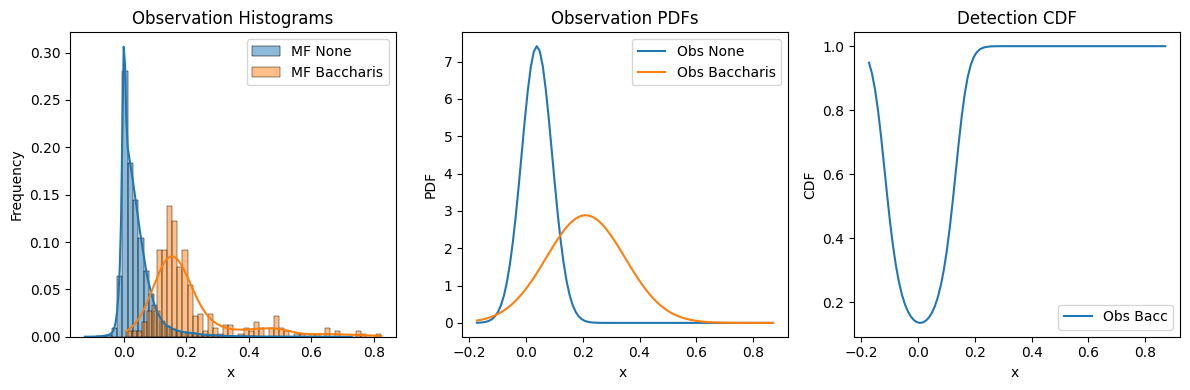

In [89]:
plot_hist(mf_max_val, roiData, detectorName='MF')

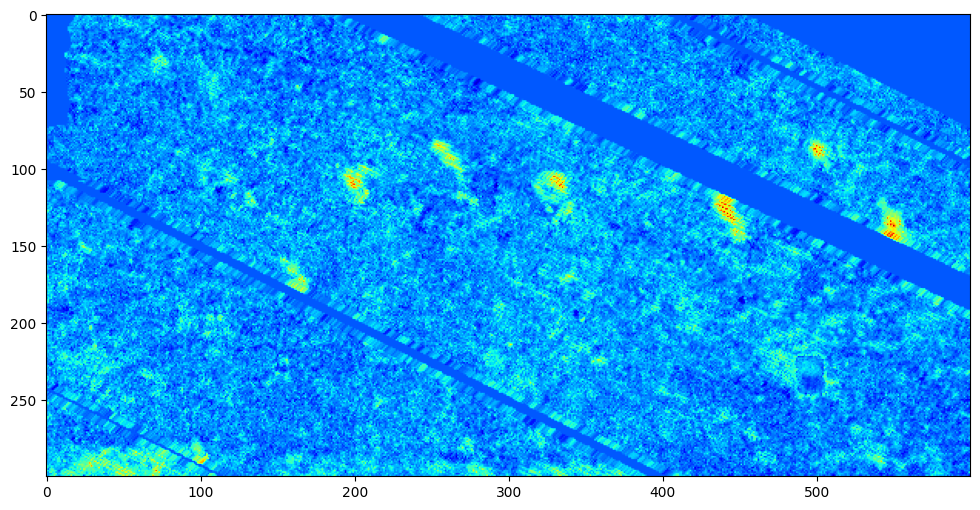

In [90]:
plt.figure(figsize=(12,6))
plt.imshow(ace_max_val, cmap='jet')

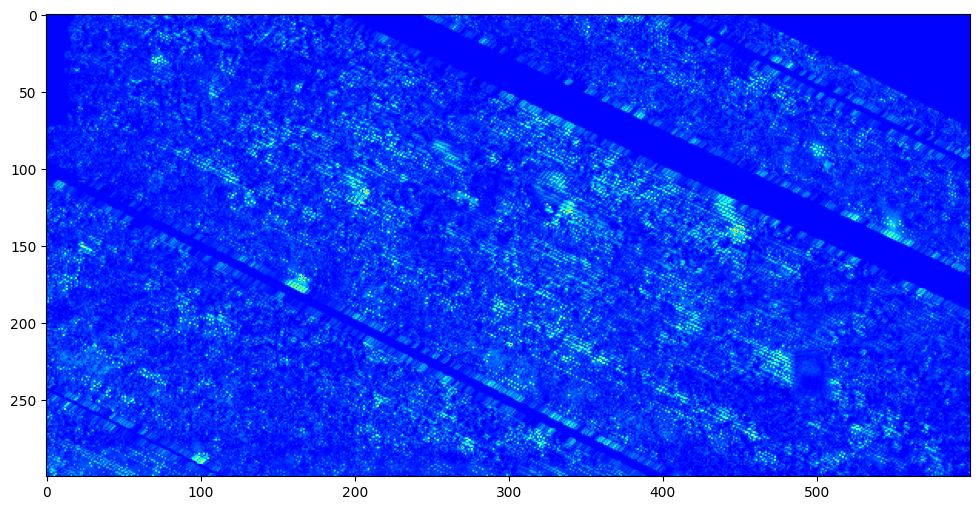

In [91]:
plt.figure(figsize=(12,6))
plt.imshow(mf_max_val, cmap='jet')

In [78]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve
import matplotlib.pyplot as plt

def plot_roc_prc(combined_scores, roiData, roc_title='ROC Curve', prc_title='Precision-Recall Curve'):
    """
    Plots the ROC and Precision-Recall curves side by side with customizable titles.
    
    Parameters:
    combined_scores (array-like): Combined detection scores (flattened).
    roiData (object): Contains the ground truth labels, specifically roiData.masks['Baccharis Halimifolia'].
    roc_title (str): Title for the ROC curve plot.
    prc_title (str): Title for the Precision-Recall curve plot.
    """
    # Flatten the combined scores and the ground truth labels (1D arrays)
    combined_scores_flattened = combined_scores.flatten()
    y_true = roiData.masks['Baccharis Halimifolia'].flatten().astype(int)  # Ground truth labels (binary)

    # Compute the ROC curve (FPR, TPR, and thresholds)
    fpr, tpr, thresholds = roc_curve(y_true, combined_scores_flattened)
    roc_auc = auc(fpr, tpr)

    # Compute precision-recall curve
    precision, recall, thresholds_prc = precision_recall_curve(y_true, combined_scores_flattened)

    # Create a figure with two subplots (side by side)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    # Plot the ROC curve (square aspect ratio)
    ax1.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc:.2f})')
    ax1.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line (random classifier)
    ax1.set_xlabel('False Positive Rate')
    ax1.set_ylabel('True Positive Rate')
    ax1.set_title(roc_title)  # Customizable title for ROC curve
    ax1.legend(loc='lower right')
    ax1.grid(True)
    ax1.set_aspect('equal', 'box')  # Make the ROC curve square

    # Plot the Precision-Recall curve
    ax2.plot(recall, precision, color='blue', label='Precision-Recall curve')
    ax2.set_xlabel('Recall')
    ax2.set_ylabel('Precision')
    ax2.set_title(prc_title)  # Customizable title for Precision-Recall curve
    ax2.legend(loc='lower left')
    ax2.grid(True)

    # Show the plots
    plt.tight_layout()  # Adjust spacing between plots
    plt.show()


In [35]:
from sklearn.decomposition import NMF

def unmix_spectra(im, n_components=2):
    """
    Perform spectral unmixing using NMF to estimate the abundance of target and background materials.
    """
    # Perform unmixing on the data matrix (image pixels reshaped)
    model = NMF(n_components=n_components, init='random', random_state=0)
    W = model.fit_transform(im.List)  # Abundance matrix
    H = model.components_  # Endmembers (target spectra)

    return W, H


Bacc: mean=0.4446848061498465, std=0.10947378933187268
None: mean=0.029061886565310658, std=0.036793386028601154


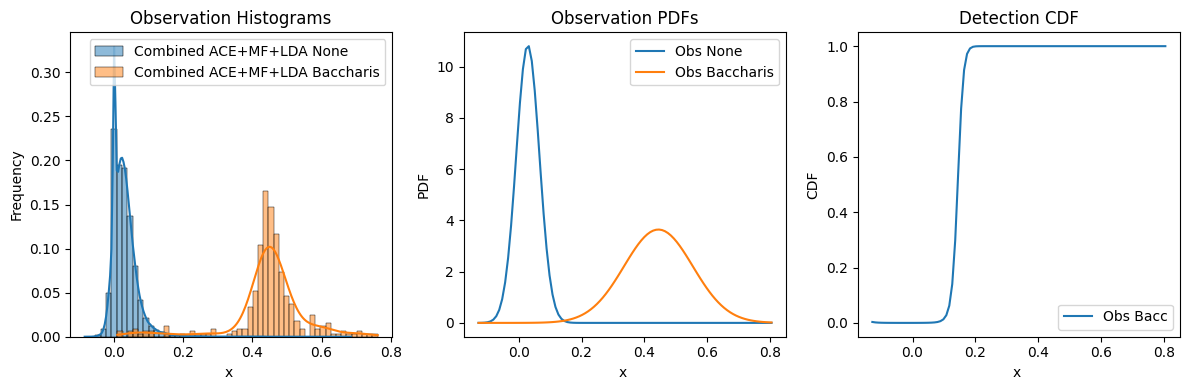

In [109]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# Flatten the detection scores
ace_flattened = ace_max_val.flatten()  # Flatten ACE scores
mf_flattened = mf_max_val.flatten()    # Flatten MF scores

# Now X_lda is already flattened to (180000, 1), we can reshape it to 1D for element-wise operations
X_lda_flattened = X_lda.flatten()

# Prepare the data for LDA model (X_train) and labels (y_train)
# Assuming that X_train contains the feature data and y_train contains the ground truth labels (target vs. background)
# X_train could be the image data (flattened) or some extracted features from the image

X_train = im.List  # Flattened image data (each pixel is a row, each spectral band is a column)
y_train = roiData.masks['Baccharis Halimifolia'].flatten().astype(int)  # Binary labels (1 for target, 0 for background)

# Train LDA on the data
lda_model = LinearDiscriminantAnalysis()
lda_model.fit(X_train, y_train)

# Predict the probabilities using LDA (probability of the target class)
lda_scores = lda_model.predict_proba(X_train)[:, 1]  # Get probability for target class (1)

# Combine the detection scores from ACE, MF, and LDA
combined_scores_flattened_lda = (ace_flattened + mf_flattened + lda_scores) / 3

# Reshape combined scores back to the spatial dimensions of the image (300, 600)
combined_scores_lda = combined_scores_flattened_lda.reshape(im.nrows, im.ncols)

# Plot combined results (histograms, ROC, etc.)
plot_hist(combined_scores_lda, roiData, detectorName='Combined ACE+MF+LDA')


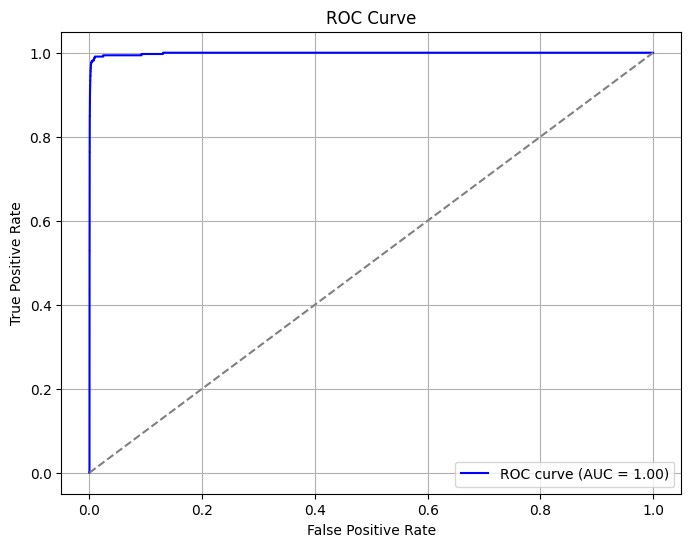

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Flatten the combined scores and the ground truth labels (1D arrays)
combined_scores_flattened_lda = combined_scores.flatten()  # Flatten the combined scores
y_true = roiData.masks['Baccharis Halimifolia'].flatten().astype(int)  # Flatten the ground truth mask and convert to binary labels

# Compute the ROC curve (FPR, TPR, and thresholds)
fpr, tpr, thresholds = roc_curve(y_true, combined_scores_flattened_lda)

# Compute the AUC (Area Under the Curve) score
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line (random classifier)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


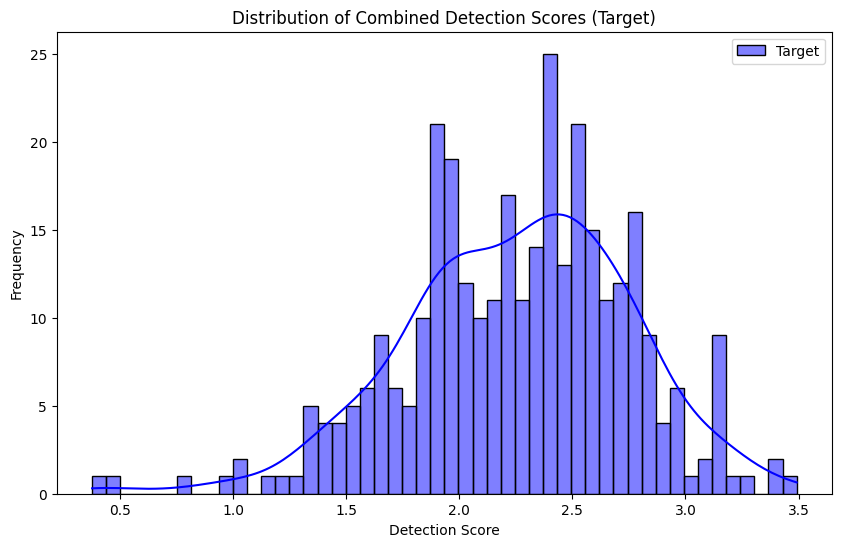

In [66]:
import seaborn as sns

# Plot histograms of detection scores for target and background
plt.figure(figsize=(10, 6))
#sns.histplot(combined_scores_flattened[y_true == 0], bins=50, color='red', label='Background', kde=True)
sns.histplot(combined_scores_flattened[y_true == 1], bins=50, color='blue', label='Target', kde=True)
plt.legend()
plt.title('Distribution of Combined Detection Scores (Target)')
plt.xlabel('Detection Score')
plt.ylabel('Frequency')
plt.show()


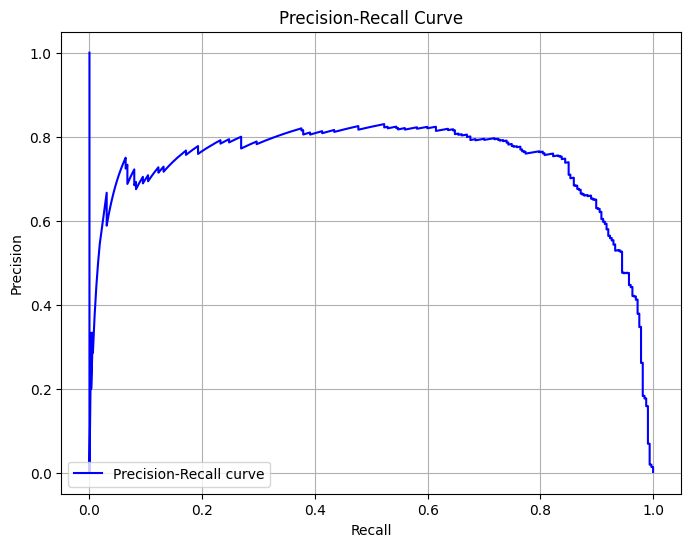

In [67]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

# Flatten the combined detection scores and ground truth labels (1D arrays)
combined_scores_flattened = combined_scores.flatten()
y_true = roiData.masks['Baccharis Halimifolia'].flatten().astype(int)

# Compute precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_true, combined_scores_flattened)

# Plot the precision-recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='blue', label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.grid(True)
plt.show()


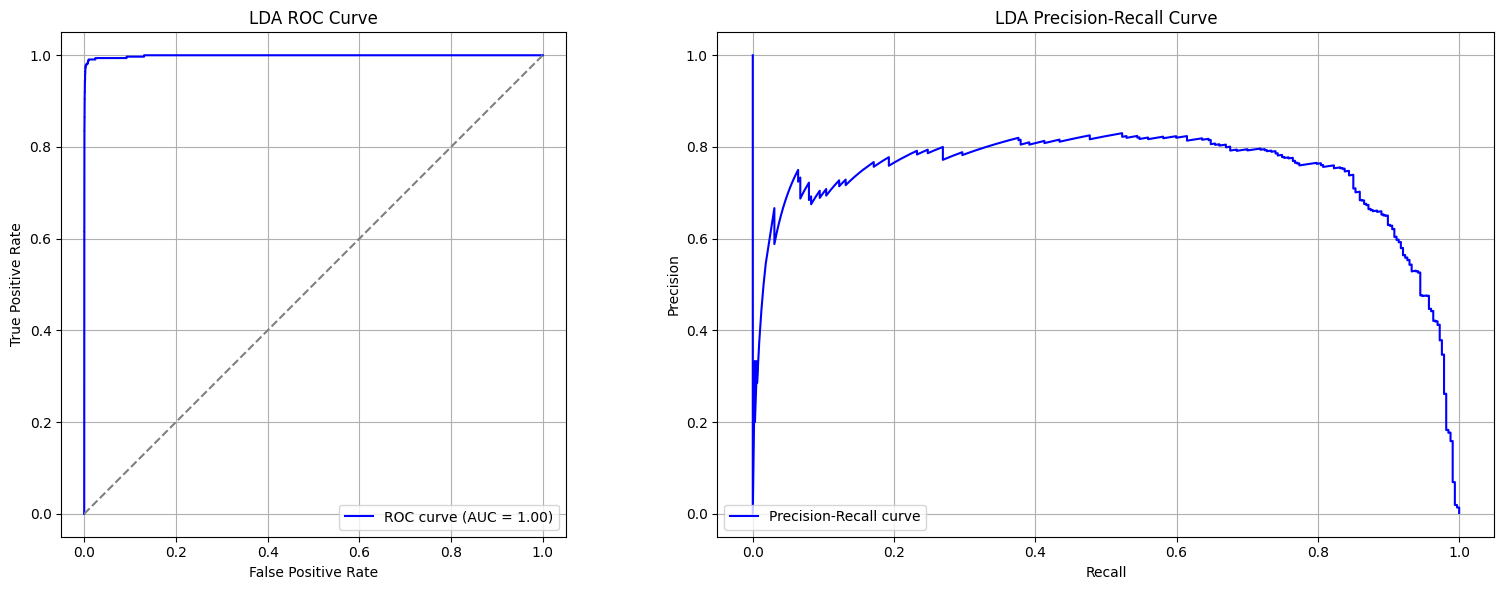

In [79]:
plot_roc_prc(combined_scores, roiData, 'LDA ROC Curve', 'LDA Precision-Recall Curve')

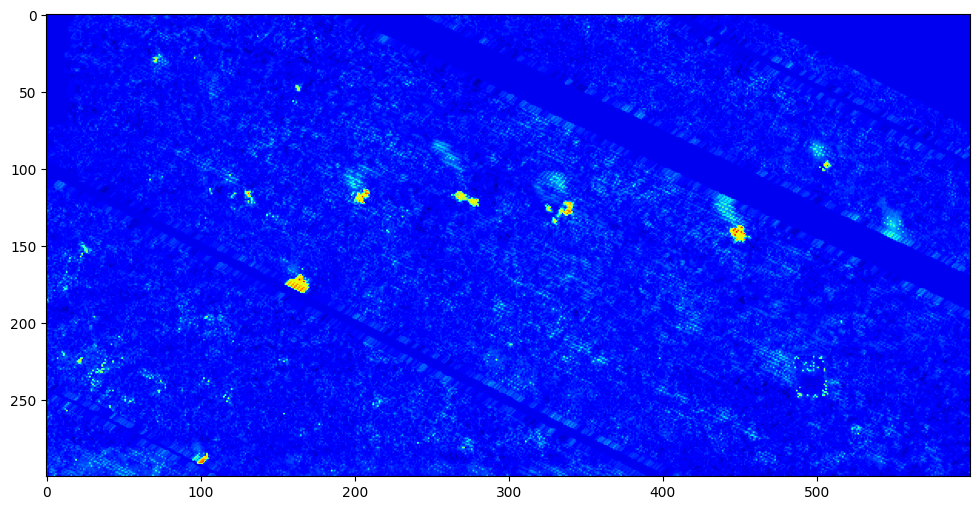

In [184]:
plt.figure(figsize=(12,6))
plt.imshow(combined_scores_lda, cmap='jet')

/Users/giasmith/.pyenv/versions/3.9.19/lib/python3.9/site-packages/sklearn/discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


Bacc: mean=0.13695378401523292, std=0.06733832893058239
None: mean=0.028522457577371547, std=0.03365788335832257


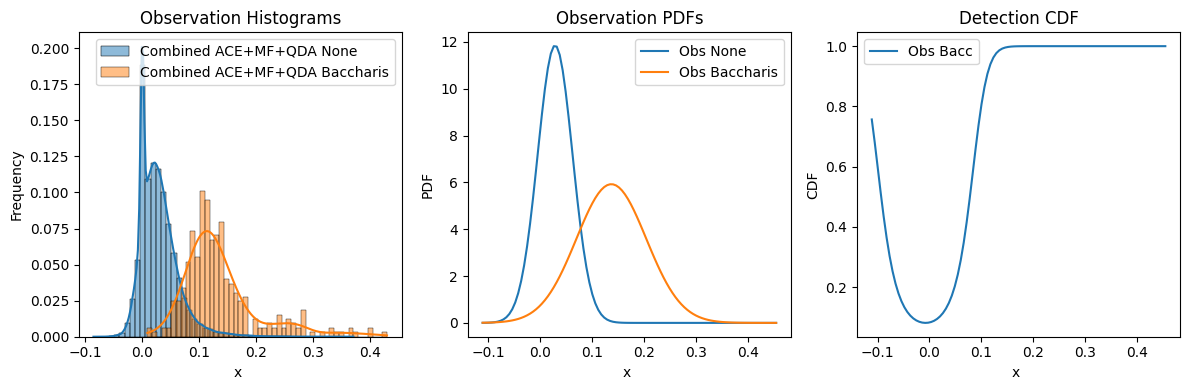

In [ ]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

# Assuming your image data (features) is in `im.List` and the target labels are in `roiData.masks['Baccharis Halimifolia']`
# Flattening the image features (if necessary, based on your data structure)
X_train = im.List  # Flattened image data (ensure this is the correct format)
y_train = roiData.masks['Baccharis Halimifolia'].flatten().astype(int)  # Binary labels (1 for target, 0 for background)

# Fit QDA model
qda_model = QuadraticDiscriminantAnalysis()
qda_model.fit(X_train, y_train)  # Fit on the features and corresponding labels

# After fitting, use QDA to predict probabilities for the target class
qda_scores = qda_model.predict_proba(X_train)[:, 1]  # Get probability of target class (Baccharis Halimifolia)

# Combine detection scores (ACE, MF, QDA)
ace_flattened = ace_max_val.flatten()  # Flatten ACE scores
mf_flattened = mf_max_val.flatten()    # Flatten MF scores

# Combine the detection scores (element-wise averaging)
combined_scores_flattened_qda = (ace_flattened + mf_flattened + qda_scores) / 3

# Reshape combined scores back to the spatial dimensions of the image (300, 600)
combined_scores_qda = combined_scores_flattened_qda.reshape(im.nrows, im.ncols)

# Plot combined results (histograms, ROC, etc.)
#plot_hist(combined_scores_qda, roiData, detectorName='Combined ACE+MF+QDA')


In [102]:
# Combine the detection scores (element-wise averaging)
combined_scores_flattened_qda = (ace_flattened + mf_flattened + qda_scores) / 3

# Reshape combined scores back to the spatial dimensions of the image (300, 600)
combined_scores_qda = combined_scores_flattened_qda.reshape(im.nrows, im.ncols)

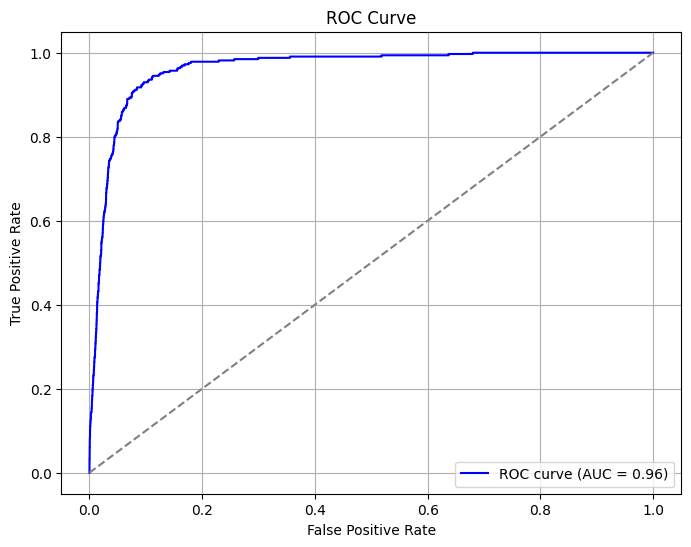

In [96]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Flatten the combined scores and the ground truth labels (1D arrays)
combined_scores_flattened = combined_scores.flatten()  # Flatten the combined scores
y_true = roiData.masks['Baccharis Halimifolia'].flatten().astype(int)  # Flatten the ground truth mask and convert to binary labels

# Compute the ROC curve (FPR, TPR, and thresholds)
fpr, tpr, thresholds = roc_curve(y_true, combined_scores_flattened)

# Compute the AUC (Area Under the Curve) score
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line (random classifier)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


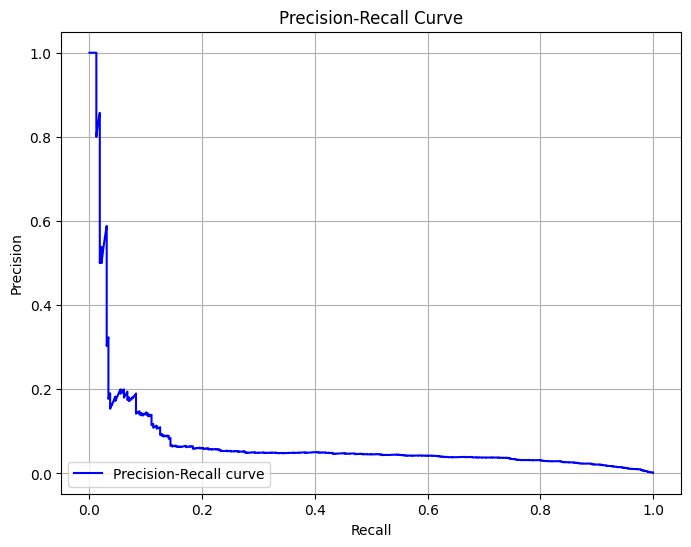

In [97]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

# Flatten the combined detection scores and ground truth labels (1D arrays)
combined_scores_flattened = combined_scores.flatten()
y_true = roiData.masks['Baccharis Halimifolia'].flatten().astype(int)

# Compute precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_true, combined_scores_flattened)

# Plot the precision-recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='blue', label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.grid(True)
plt.show()

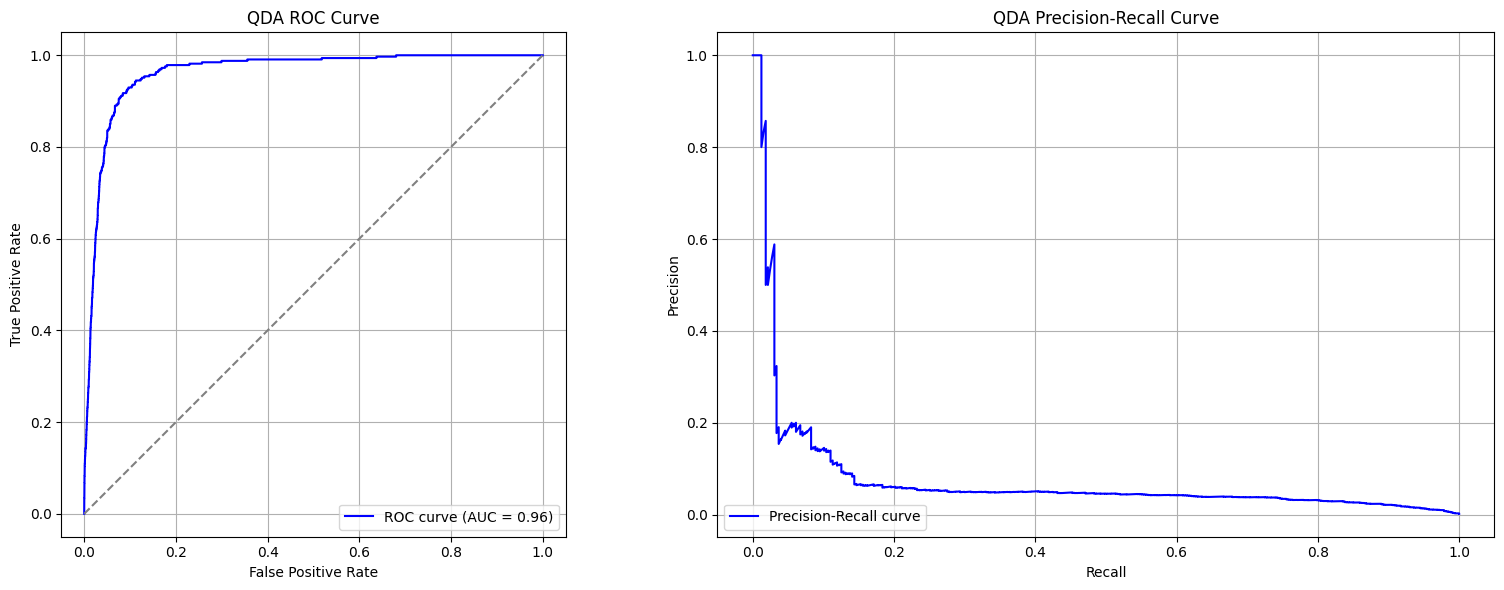

In [ ]:
plot_roc_prc(combined_scores, roiData, 'QDA ROC Curve', 'QDA Precision-Recall Curve')

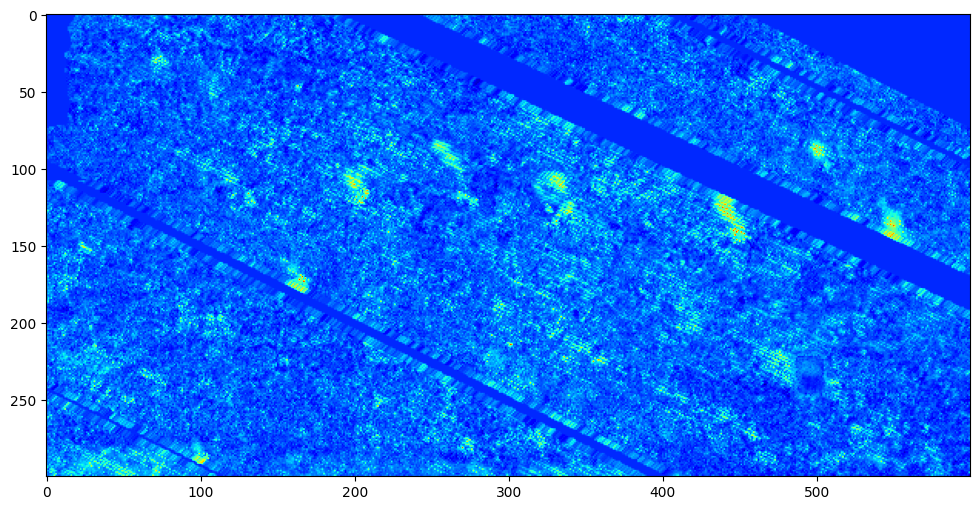

In [186]:
plt.figure(figsize=(12,6))
plt.imshow(combined_scores_qda, cmap='jet')

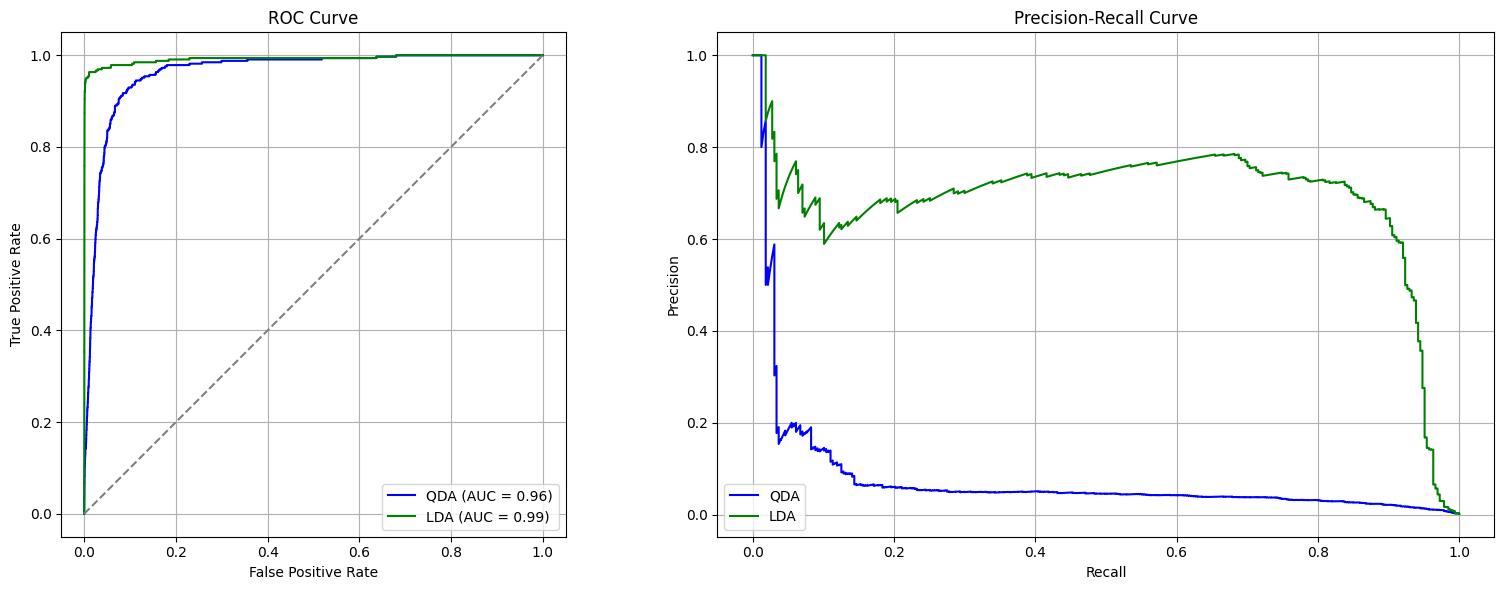

In [185]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score

def plot_roc_prc_combined(qda_scores, lda_scores, y_true, qda_title="QDA", lda_title="LDA", nn_title='NN'):
    """
    Plots the ROC and Precision-Recall curves for both QDA, LDA, and NN in a single plot each.
    
    Parameters:
    qda_scores (array-like): QDA model detection scores.
    lda_scores (array-like): LDA model detection scores.
    y_true (array-like): Ground truth labels for Baccharis Halimifolia.
    y_pred_probs_baccharis (array-like): Predicted probabilities for Baccharis Halimifolia class.
    qda_title (str): Title for the QDA curves.
    lda_title (str): Title for the LDA curves.
    nn_title (str): Title for the NN curves.
    """
    # Compute ROC curves for QDA, LDA, and NN
    fpr_qda, tpr_qda, _ = roc_curve(y_true, qda_scores)
    roc_auc_qda = auc(fpr_qda, tpr_qda)
    
    fpr_lda, tpr_lda, _ = roc_curve(y_true, lda_scores)
    roc_auc_lda = auc(fpr_lda, tpr_lda)

    # Compute Precision-Recall curves for QDA, LDA, and NN
    precision_qda, recall_qda, _ = precision_recall_curve(y_true, qda_scores)
    precision_lda, recall_lda, _ = precision_recall_curve(y_true, lda_scores)

    # Create a figure with 2 subplots (one for ROC, one for Precision-Recall)
    fig, axs = plt.subplots(1, 2, figsize=(16, 6))

    # Plot both ROC curves in one plot
    axs[0].plot(fpr_qda, tpr_qda, color='blue', label=f'{qda_title} (AUC = {roc_auc_qda:.2f})')
    axs[0].plot(fpr_lda, tpr_lda, color='green', label=f'{lda_title} (AUC = {roc_auc_lda:.2f})')
    axs[0].plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line (random classifier)
    axs[0].set_xlabel('False Positive Rate')
    axs[0].set_ylabel('True Positive Rate')
    axs[0].set_title('ROC Curve')
    axs[0].legend(loc='lower right')
    axs[0].grid(True)
    axs[0].set_aspect('equal', 'box')  # Make the ROC curve square

    # Plot both Precision-Recall curves in one plot
    axs[1].plot(recall_qda, precision_qda, color='blue', label=f'{qda_title}')
    axs[1].plot(recall_lda, precision_lda, color='green', label=f'{lda_title}')
    axs[1].set_xlabel('Recall')
    axs[1].set_ylabel('Precision')
    axs[1].set_title('Precision-Recall Curve')
    axs[1].legend(loc='lower left')
    axs[1].grid(True)

    # Adjust layout for better spacing
    plt.tight_layout()
    plt.show()

# Example usage:
# Assuming qda_scores, lda_scores, and y_pred_probs_baccharis are already defined
# and y_true contains the true binary labels for Baccharis Halimifolia
plot_roc_prc_combined(combined_scores_flattened_qda, combined_scores_flattened_lda, y_true)
